In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cmcrameri import cm as  cmc
import matplotlib as mpl
import pandas as pd
import xarray as xr
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_plots as mp
import model1_explore as me
import model1 as mod1
from scipy.stats import norm, beta
from statsmodels.base.model import GenericLikelihoodModel
import palettable as pal

import Utilities as util


In [2]:
loc_model = '../mod/model1/'
loc_fig = '../fig/model1/'

dh = 200
dd = .2
dH = 400 
dD = .4
N = 5000

prop = {'dH' : dH, 'dD' : dD, 'N' : N }
prop = '_'.join([f'{x}={prop[x]}' for x in prop]).replace('.' ,'_')
loc_model = loc_model + prop

# read data
# explorative
# 0. overview
ds_c = xr.open_dataset(loc_model + 'expl_hist_clouds.nc')
T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)



# 1. cs -> cs

# 2. c -> cs
ds_local = xr.open_dataset(loc_model + 'expl_local_param.nc')

# 3. cs -> c
ds_cs_c = xr.open_dataset(loc_model + 'expl_hist_cs_to_c.nc')
ds_cs_c = ds_cs_c.rename({'h': 'd', 'd': 'h'})

# 4. c -> c
df = pd.read_csv(loc_model + 'expl_example_bin_data.csv')
df_bin_fit = pd.read_csv(loc_model + 'expl_examble_bin_fit.csv')
# ds_local local param 

# global model1
# df_glob_c_to_c_cod = pd.read_csv(loc_model + 'glob_c_to_c_cod.csv')
# ds_theta = xr.open_dataset(loc_model + 'glob_theta.nc')

# loc_model = '../mod/model1/'
# df_cs_c = pd.read_csv(loc_model + 'cstc_param.csv')


In [3]:
ds_local

<xarray.Dataset>
Dimensions:  (est: 2, method: 2, mu_d: 28, mu_h: 79)
Coordinates:
  * mu_h     (mu_h) float64 100.0 300.0 500.0 ... 1.53e+04 1.55e+04 1.57e+04
  * mu_d     (mu_d) float64 -1.0 -0.8 -0.6 -0.4 -0.2 ... 3.6 3.8 4.0 4.2 4.4
  * method   (method) object 'ML' 'MoM'
  * est      (est) object 'coef' 'bse'
Data variables: (12/26)
    p_cs     (mu_h, mu_d) float64 ...
    n_c      (mu_h, mu_d) float64 ...
    dH       (mu_h, mu_d) float64 ...
    dD       (mu_h, mu_d) float64 ...
    mu       (mu_h, mu_d) float64 ...
    sigma    (mu_h, mu_d) float64 ...
    ...       ...
    AIC_b    (mu_h, mu_d, method) float64 ...
    BIC_b    (mu_h, mu_d, method) float64 ...
    KS_b     (mu_h, mu_d, method) float64 ...
    CM_b     (mu_h, mu_d, method) float64 ...
    AD_b     (mu_h, mu_d, method) float64 ...
    conv_b   (mu_h, mu_d, method) float64 ...
Attributes:
    dh:       200
    dd:       0.2
    p_cscs:   0.7979449866697128

## 0. Cloud distribution

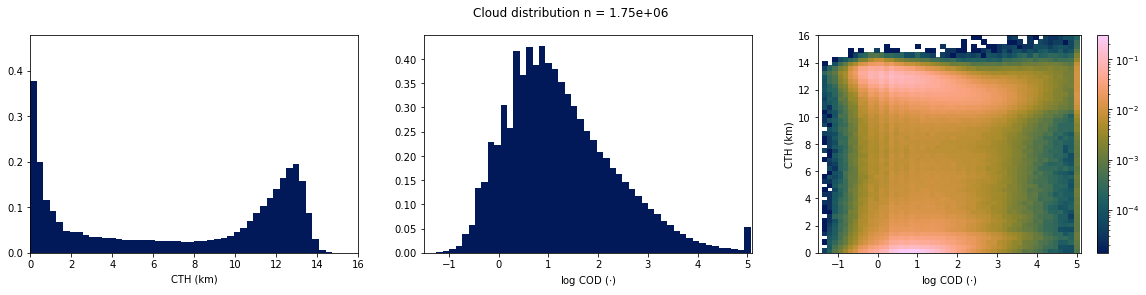

In [4]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=2, n=16)

dedges, hedges, freq = ds_c.dedges.data, ds_c.hedges.data, ds_c.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
# fig.savefig(loc_fig + 'expl_cloud_distr.png')

# .colorbrewer.sequential import Blues_8
# ax.imshow(data, cmap=Blues_8.mpl_colormap)


In [5]:
T = T_total#.iloc[:-1]
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T = T.rename(
            columns = classes, 
             index = classes
            )
T

loc_model1 = '../mod/model1/'
T_total_data = pd.read_csv(loc_model1 + 'expl_transition_ctypes.csv', index_col = 0)
T_data = T_total_data#.iloc[:-1]

# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T_data = T_data.rename(
            columns = classes, 
             index = classes
            ).drop(['invalid pixel'], axis = 1).drop(['invalid pixel'])
T_data.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')

T_diff = (T_data - T)

T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)

T_total

import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)

T_data.columns.name = 'To →'
T_data.index.name = 'From ↓'

T_data.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')
# classes

FileNotFoundError: [Errno 2] File ../mod/model1/expl_transition_ctypes.csv does not exist: '../mod/model1/expl_transition_ctypes.csv'

In [12]:
Q = np.array(T_data[:-1])
Q = Q / Q.sum(axis = 1)
Q.sum(axis = 1)
evals, evecs = np.linalg.eig(Q.T)
evals

NameError: name 'T_data' is not defined

In [57]:
#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
Q = np.array(T_data[:-1])
Q = Q / Q.sum(axis = 1)
Q.sum(axis = 1)
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
[round(val, 2) for val in stationary]

[0.23, 0.15, 0.06, 0.2, 0.08, 0.07, 0.15, 0.0, 0.01, 0.05]

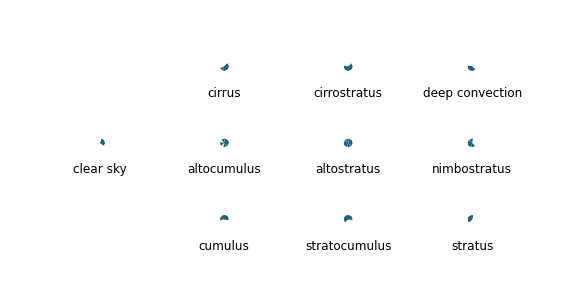

In [6]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

T = T_diff

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}

node_size = T.loc['All', node_names] * 5000
edge_widths = [w * T.loc['All',edge[0]] * 1000 for (*edge, w) in G.edges.data('weight')] # weight * node size
labels = {item:item for item in node_names}

fig = plt.figure(figsize = (10, 5))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size = node_size,
        node_color =  '#72BCD9',
#         alpha = 0,
)

nx.draw_networkx_edges(G, pos, width=edge_widths,
                       node_size = node_size,
                       edge_color = '#21637D',
                       connectionstyle='arc3, rad=.15'
 )

pos_labels = {k: v + [0, -.35] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels, font_color = 'black')
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)

plt.savefig(loc_fig + 'graph_diff.png', transparent=True)

In [7]:
# edge_widths = [(w * 10 , print(T.loc['All',edge[0]])) for (*edge, w) in G.edges.data('weight')]


# 1. Clear sky to Clear sky

In [8]:
# no exploration needed
ds_local.p_cscs

0.7308294268298162

# 2. Cloud to clear sky

In [9]:
dh = ds_local.dh
dd = ds_local.dd
mu_h = ds_local.mu_h # m
mu_d = ds_local.mu_d
n_h = len(mu_h)
n_d = len(mu_d)

ds_local

<xarray.Dataset>
Dimensions:  (est: 2, method: 2, mu_d: 28, mu_h: 79)
Coordinates:
  * mu_h     (mu_h) float64 100.0 300.0 500.0 ... 1.53e+04 1.55e+04 1.57e+04
  * mu_d     (mu_d) float64 -1.0 -0.8 -0.6 -0.4 -0.2 ... 3.6 3.8 4.0 4.2 4.4
  * method   (method) object 'ML' 'MoM'
  * est      (est) object 'coef' 'bse'
Data variables: (12/26)
    p_cs     (mu_h, mu_d) float64 ...
    n_c      (mu_h, mu_d) float64 ...
    dH       (mu_h, mu_d) float64 ...
    dD       (mu_h, mu_d) float64 ...
    mu       (mu_h, mu_d) float64 ...
    sigma    (mu_h, mu_d) float64 ...
    ...       ...
    AIC_b    (mu_h, mu_d, method) float64 ...
    BIC_b    (mu_h, mu_d, method) float64 ...
    KS_b     (mu_h, mu_d, method) float64 ...
    CM_b     (mu_h, mu_d, method) float64 ...
    AD_b     (mu_h, mu_d, method) float64 ...
    conv_b   (mu_h, mu_d, method) float64 ...
Attributes:
    dh:       200
    dd:       0.2
    p_cscs:   0.7308294268298162

5000

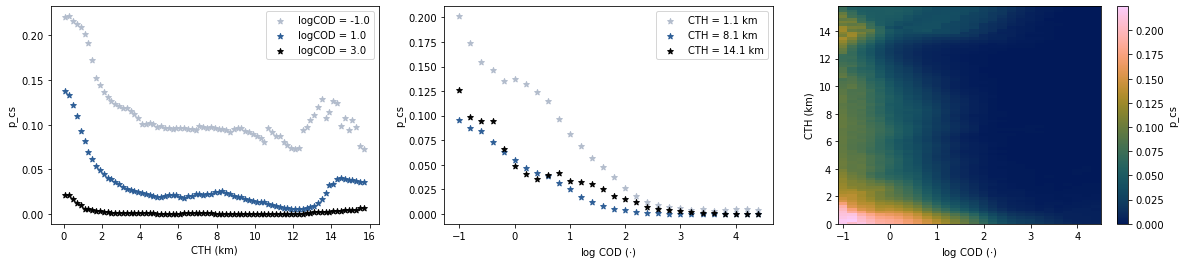

In [7]:
# fig, ax = mp.plotLocalParam(ds_local.n_c, logscale = True)
# fig.savefig(loc_fig + 'expl_local_n_c.png')

# fig, ax = mp.plotLocalParam(ds_local.n_cc, logscale = True)
# fig.savefig(loc_fig + 'expl_local_n_cc.png')

fig, ax = mp.plotLocalParam(ds_local.p_cs, logscale = False, 
#                             vmax = .8,
                            cth_kwargs = {'ind' : [0, 10, 20]}, cod_kwargs = {'ind' : [5, 40, 70]})
fig.savefig(loc_fig + 'expl_local_p_cs.png')

# fig, ax = mp.plotLocalParam(ds_local.dH, logscale = False)


# fig, ax = mp.plotLocalParam(ds_local.dD, logscale = False)


# 3. Clear sky to Cloud

Are D_t+1 and H_t+ 1 independent?


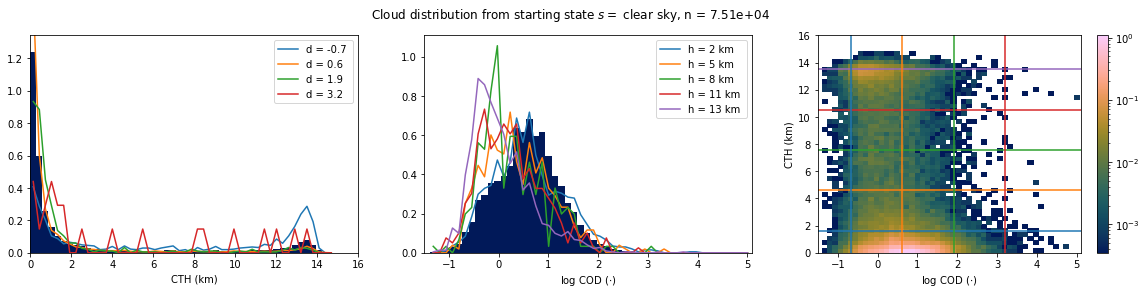

In [14]:
freq = ds_cs_c.freq.data

fig, ax = mp.plotCloudHist_f(ds_cs_c.dedges.data, ds_cs_c.hedges.data, ds_cs_c.freq.data,
                          title = f'Cloud distribution from starting state $s = $ clear sky, n = {ds_cs_c.freq.data.sum().sum():.2e}',
                         density = True)

# theta = ds_theta.theta3
# mp.plotCTHBeta(ax[0], *theta[0:2])
# mp.plotCTHBetaMix(ax[0], *theta[2:7].data)
# mp.plotCODNormal(ax[1], *theta[7:9])

# fig.savefig(loc_fig + 'expl_cs_cloud_distr_3.png')
# theta

dh = (ds_cs_c.hedges[1] - ds_cs_c.hedges[0]).data

for i in np.array([ 5, 15, 25 , 35, 45]):
    h_ind = i
    h = ds_cs_c.hedges[h_ind].data + dh/2
    sub = ds_cs_c.sel(h = h_ind)
#     plt.plot(sub.dedges[:-1] + dh / 2, sub.freq)    
    n, x, _ = mp.hist_f(ax[1], sub.dedges, sub.freq, density = True, alpha = 0, color = 'red')
    bin_centers = 0.5*(x[1:]+x[:-1])
    p = ax[1].plot(bin_centers,n,  label = f'h = {h*1e-3:.0f} km ')
    
    # show line of conditional distribution in joint. 
    ax[2].axhline(h * 1e-3, color = p[0].get_color())
    
ax[1].legend()
# plt.show()

dd = (ds_cs_c.dedges[1] - ds_cs_c.dedges[0]).data

for i in np.array([ 5, 15, 25 , 35]):
    d_ind = i
    d = ds_cs_c.dedges[d_ind].data + dd/2
    sub = ds_cs_c.sel(d = d_ind)
#     plt.plot(sub.dedges[:-1] + dh / 2, sub.freq)
    n, x, _ = mp.hist_f(ax[0], sub.hedges / 1000, sub.freq, histtype = 'step', density = True,  alpha = 0, color = 'red')
    bin_centers = 0.5*(x[1:]+x[:-1])
    p = ax[0].plot(bin_centers,n,  label = f'd = {d:.1f} ')
    
    ax[2].axvline(d, color = p[0].get_color())

    
    
ax[0].legend()

fig.savefig(loc_fig + 'expl_cs_cloud_distr_indp')

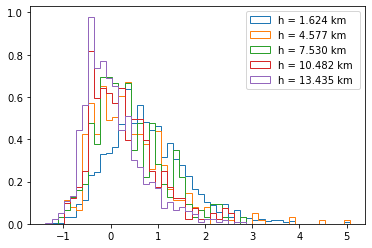

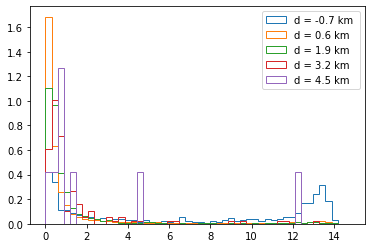

In [73]:

dh = (ds_cs_c.hedges[1] - ds_cs_c.hedges[0]).data

for i in np.array([ 5, 15, 25 , 35, 45]):
    h_ind = i
    h = ds_cs_c.hedges[h_ind].data + dh/2
    sub = ds_cs_c.sel(h = h_ind)
#     plt.plot(sub.dedges[:-1] + dh / 2, sub.freq)
    mp.hist_f(plt, sub.dedges, sub.freq, histtype = 'step', density = True, label = f'h = {h*1e-3:.3f} km ')
    
plt.legend()
plt.show()

dd = (ds_cs_c.dedges[1] - ds_cs_c.dedges[0]).data

for i in np.array([ 5, 15, 25 , 35, 45]):
    d_ind = i
    d = ds_cs_c.dedges[d_ind].data + dd/2
    sub = ds_cs_c.sel(d = d_ind)
#     plt.plot(sub.dedges[:-1] + dh / 2, sub.freq)
    mp.hist_f(plt, sub.hedges / 1000, sub.freq, histtype = 'step', density = True, label = f'd = {d:.1f} km ')
    
plt.legend()
plt.show()

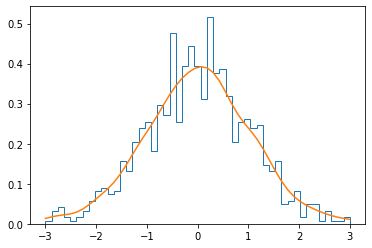

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

noise = np.random.normal(0, 1, (1000, ))
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, bins=np.linspace(-3, 3, 50), 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

In [56]:
ds_cs_c

<xarray.Dataset>
Dimensions:  (d: 50, dedges: 51, h: 50, hedges: 51)
Coordinates:
  * dedges   (dedges) float64 -1.38 -1.251 -1.123 -0.9936 ... 4.808 4.937 5.066
  * hedges   (hedges) float64 0.0 295.3 590.6 ... 1.417e+04 1.447e+04 1.476e+04
Dimensions without coordinates: d, h
Data variables:
    freq     (d, h) float64 1.0 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

# 4. Cloud to Cloud

In [4]:
df

,Unnamed: 0,Unnamed: 0.1,h_t,d_t,ct,cloud,h_t_next,d_t_next,ct_next,cloud_next,dh,dd,bincenter_h,bincenter_d
0,24,24,326.873169,0.139769,2.0,cloud,291.164337,0.639063,2.0,cloud,-35.708832,0.499294,500.0,0
1,62,62,210.895767,0.361638,2.0,cloud,90.950706,1.164219,2.0,cloud,-119.945061,0.802581,500.0,0
2,333,333,326.873169,0.139769,2.0,cloud,291.164337,0.639063,2.0,cloud,-35.708832,0.499294,500.0,0
3,396,396,316.801453,-0.112456,2.0,cloud,388.219116,1.235546,2.0,cloud,71.417664,1.348002,500.0,0
4,398,398,358.003937,-0.104293,2.0,cloud,339.691711,-0.038739,2.0,cloud,-18.312225,0.065554,500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414816,21745,21745,12221.577148,3.101270,7.0,cloud,11750.953125,2.840289,7.0,cloud,-470.624023,-0.260981,12500.0,3
414817,22883,22883,12221.577148,3.101270,7.0,cloud,11750.953125,2.840289,7.0,cloud,-470.624023,-0.260981,12500.0,3
414818,23722,23722,12119.028320,2.798944,7.0,cloud,11869.982422,5.065683,10.0,cloud,-249.045898,2.266739,12500.0,3
414819,23968,23968,12578.666016,2.700791,7.0,cloud,12653.440430,2.810764,7.0,cloud,74.774414,0.109974,12500.0,3


500.0 0.0


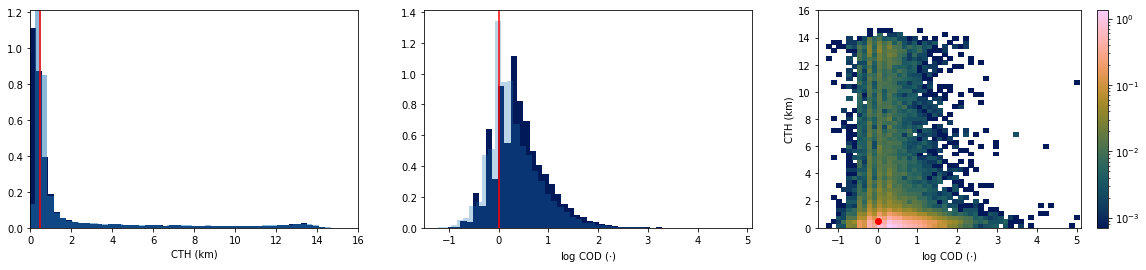

4500.0 0.0


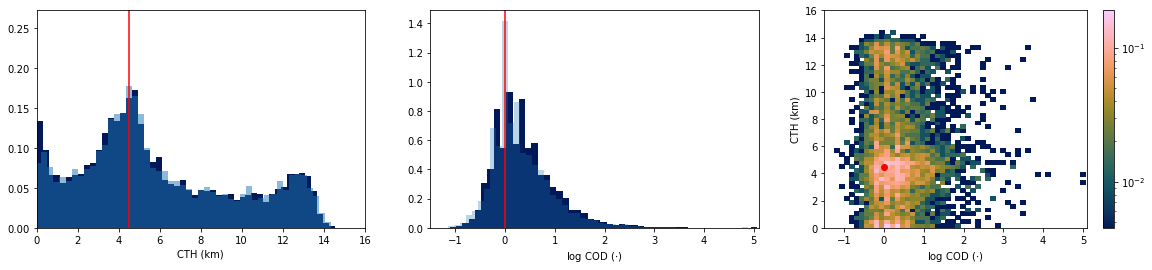

8500.0 0.0


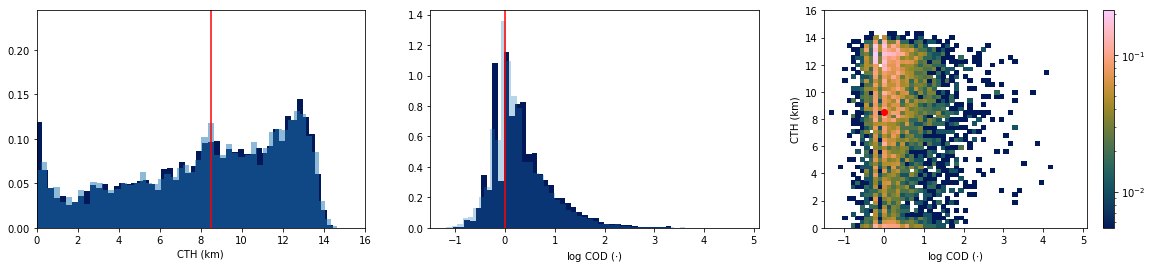

12500.0 0.0


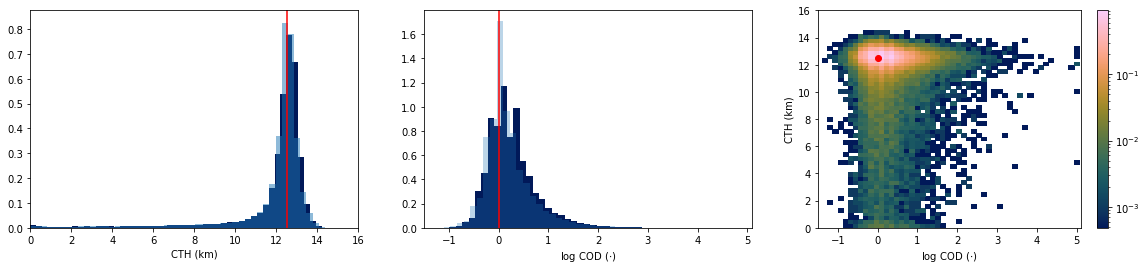

500.0 1.0


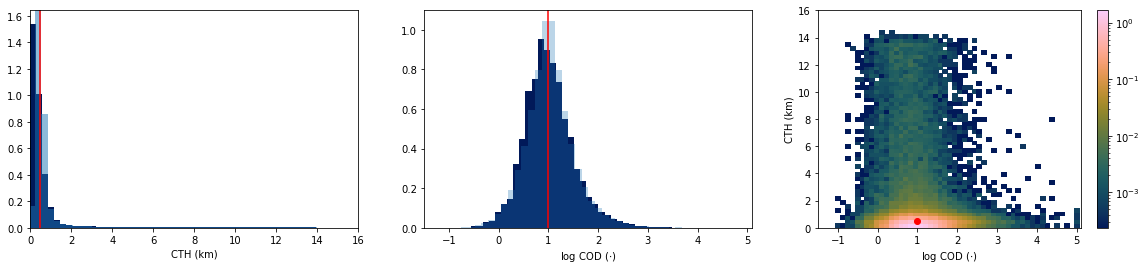

4500.0 1.0


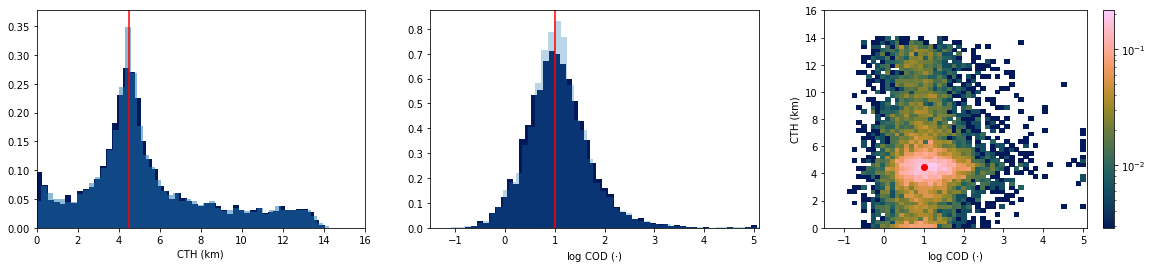

8500.0 1.0


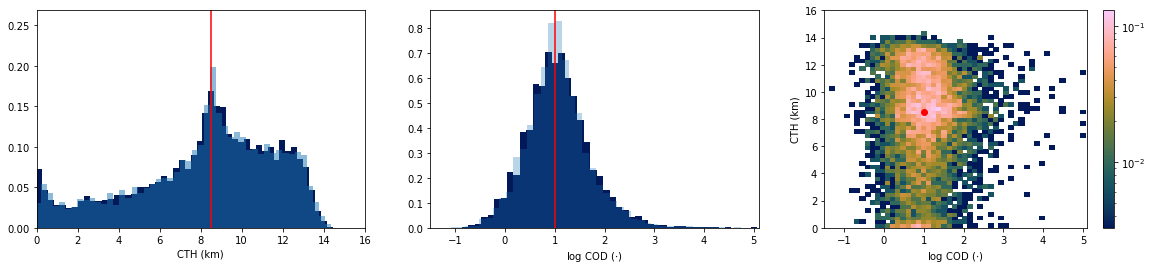

12500.0 1.0


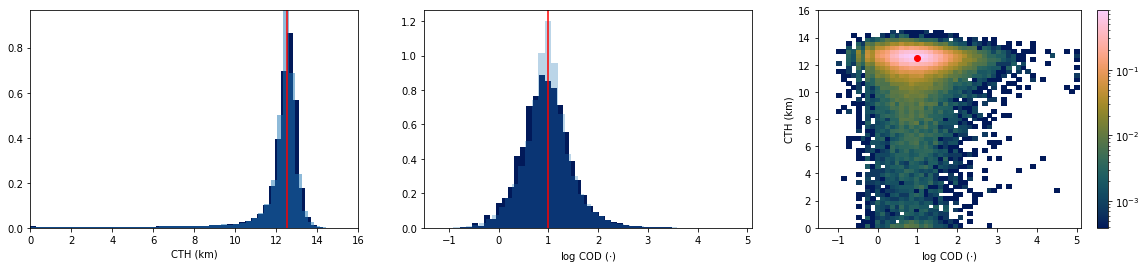

500.0 2.0


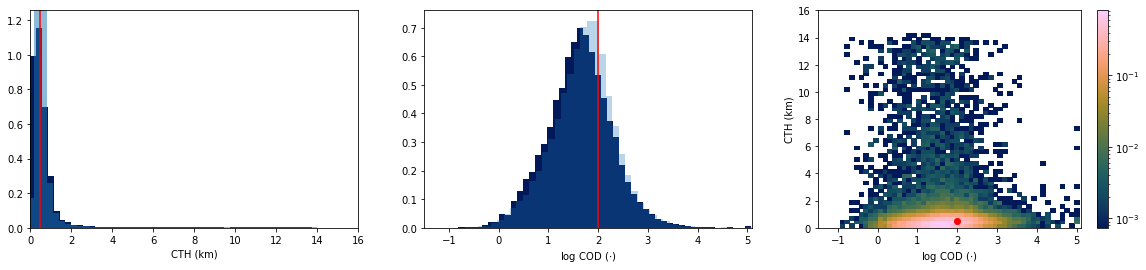

4500.0 2.0


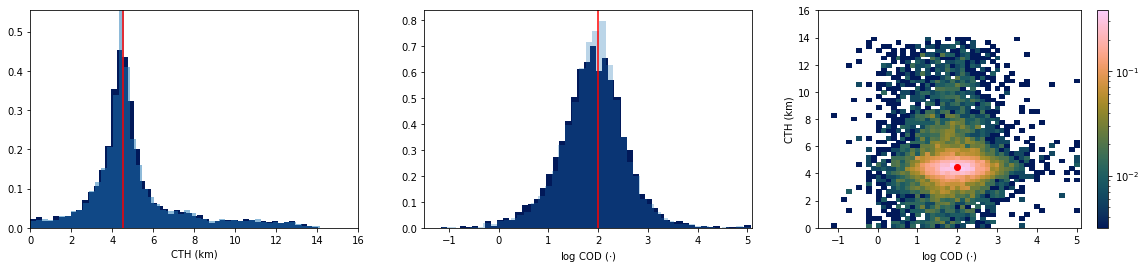

8500.0 2.0


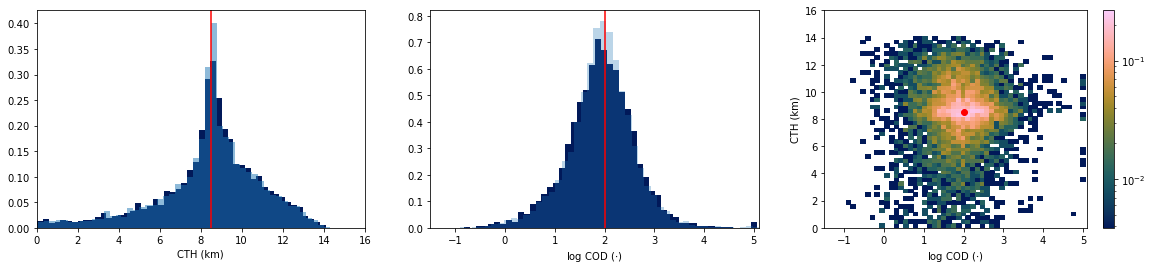

12500.0 2.0


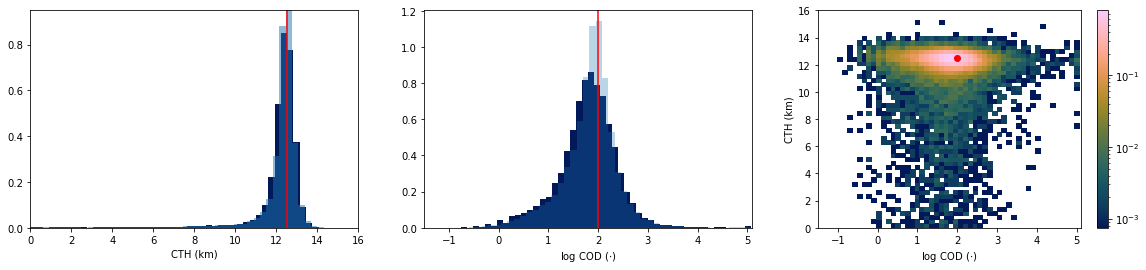

500.0 3.0


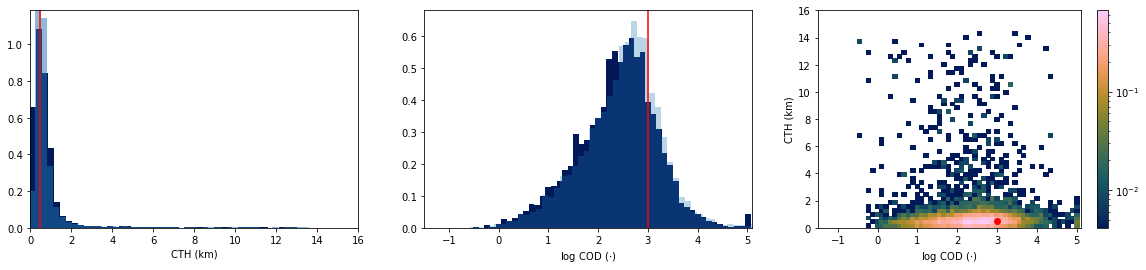

4500.0 3.0


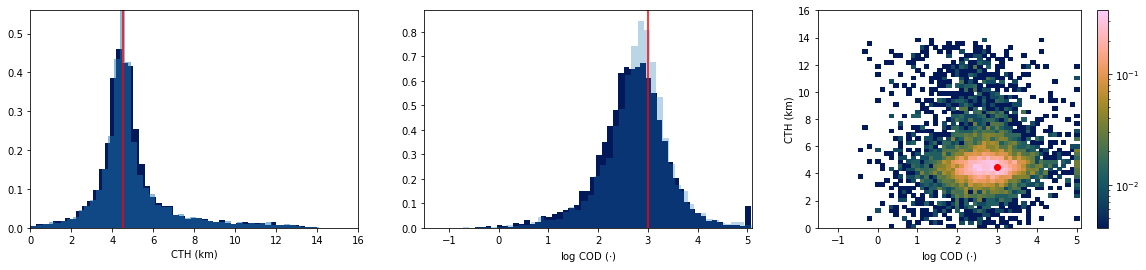

8500.0 3.0


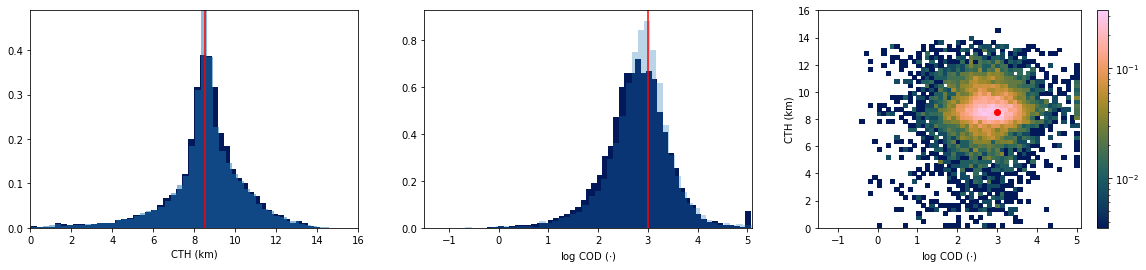

12500.0 3.0


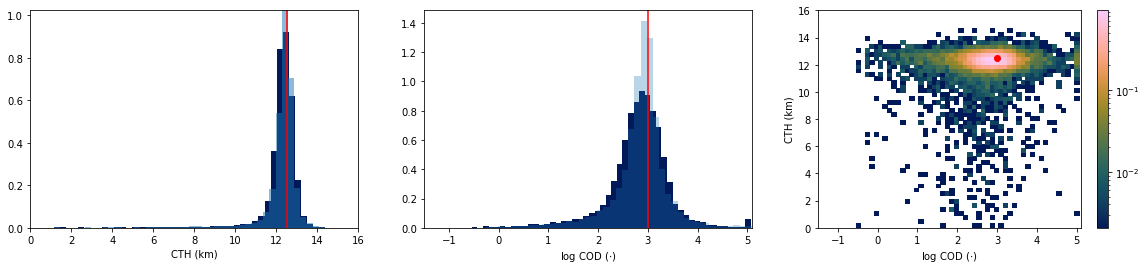

In [15]:
hlim = mp.hlim
dlim = mp.dlim

fits = []
fits_sb = []

coef = np.zeros((len(df_bin_fit), 5))
bse = np.zeros((len(df_bin_fit), 5))

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
    print(h,d)
    
    fig, ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint

    # bin centers
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')

    ax[0].hist((df_bin.dh + h) * 1e-3, bins = 50, alpha = .5, density = True)
    ax[1].hist(df_bin.dd + d, bins = 50, alpha = .3,  density = True)
    plt.show()
    
#     fit = me.fitMixBetaCTH(df_bin.h_t_next)
#     coef[idx, :] = fit.params
#     bse[idx, :] = fit.bse
#     fits.append(fit)
    
#     fit_sb = me.fitBetaCTH(df_bin.h_t_next)
#     fits_sb.append(fit_sb)
    
#     # fits
#     # cod
#     mom = MoM_sb(ml.CTHtoUnitInt(df_bin.h_t_next))
#     mp.plotCTHBeta(ax[0], *mom, label = 'Beta MoM', color = 'blue')
#     mp.plotCTHBeta(ax[0], param.alpha, param.beta)
#     mp.plotCTHBetaMix(ax[0], param.alpha1, param.beta1, param.alpha2, param.beta2, param.p.values[0])
#     mp.plotCODNormal(ax[1], param.mu, param.sigma)
    
#     fig.savefig(loc_fig + f'expl_bins{idx}.png')
#     if idx == 0:
#         break

In [6]:
i = 0
def AIC(k, L):
    ### L maximized log likelihood
    return 2 * k - 2 * L

def BIC(k, L, n):
    ### L maximized log likelihood
    return k * np.log(n) - 2 * L

def MoM_sb(x):
    m1 = x.mean()
    m2 = (x**2).mean()
    alpha = m1 * (m1 - m2) /(m2 - m1**2)
    beta = (m1/m2 - 1) * (alpha +1)
    return alpha , beta

mom = np.zeros((len(df_bin_fit),2))

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    
    mom[idx,:] = MoM_sb(ml.CTHtoUnitInt(df_bin.h_t_next))
#     print(mom)
    
    
for fit_mb, fit_sb in zip(fits, fits_sb) :
#     print(fit.summary())
    print(i)
    print(fit_mb.llf, fit_sb.llf)
    print(AIC(5, fit_mb.llf), AIC(2, fit_sb.llf))
    print(BIC(5, fit_mb.llf, fit_mb.nobs), BIC(2, fit_sb.llf, fit_sb.nobs))
    print(fit_sb.params)
    print(fit_sb.params - 2*fit_sb.bse, 'lower')
    print(fit_sb.params + 2*fit_sb.bse, 'upper')
    print(mom[i,:])
# dir(fit)
    
    i+=1



NameError: name 'fits' is not defined

In [19]:
fit.summary()

NameError: name 'fit' is not defined

## local behaviour parameters

## cod

Text(0.5, 1.0, '$\\sigma(s)$')

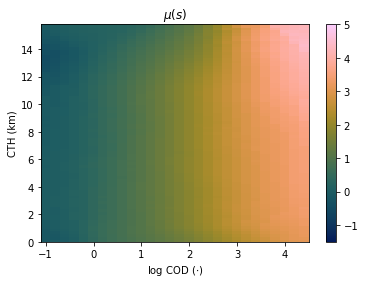

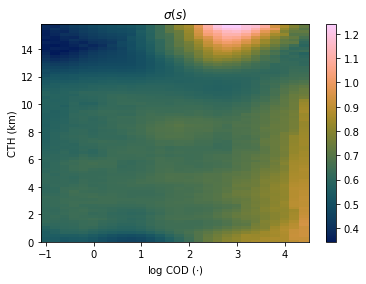

In [16]:
fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax,ds_local.mu, add_labels = False, vmin = -1.5, vmax = 5)
plt.title('$\mu(s)$')
# fig.savefig(loc_fig + 'expl_local_mu.png')

fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax,ds_local.sigma, add_labels = False)
plt.title('$\sigma(s)$')
# fig.savefig(loc_fig + 'expl_local_sigma.png')


# fig, ax = mp.plotLocalParam(ds_local.mu, vmin = -1.5, vmax = 5)
# fig.savefig('../fig/model1/expl_local_mu.png')

# fig, ax = mp.plotLocalParam(ds_local.sigma)#, vmax = 1.2)
# fig.savefig('../fig/model1/expl_local_sigma.png')

## CTH

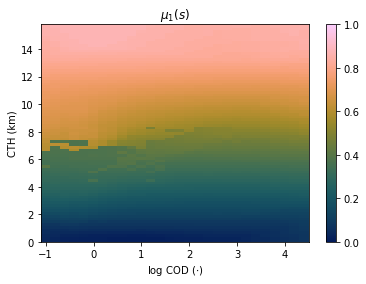

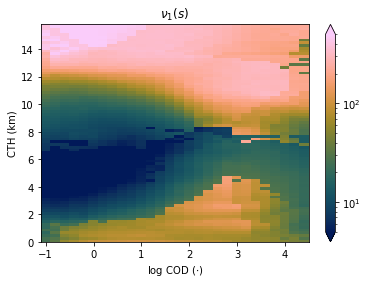

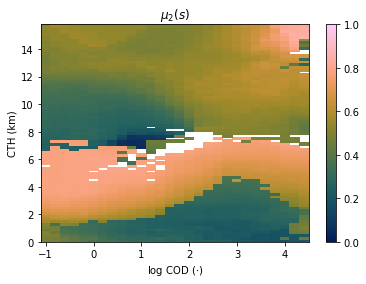

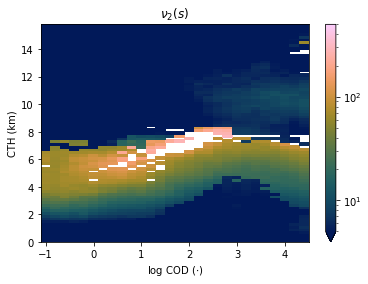

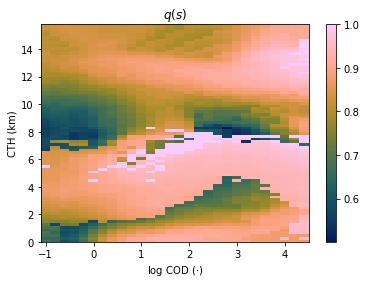

In [17]:
alpha1 = ds_local.alpha1.where(ds_local.p >=.5, ds_local.alpha2)
beta1  = ds_local.beta1.where(ds_local.p >=.5, ds_local.beta2)

alpha2 = ds_local.alpha1.where(ds_local.p <.5, ds_local.alpha2)
beta2  = ds_local.beta1.where(ds_local.p <.5, ds_local.beta2)

p = ds_local.p.where(ds_local.p > .5,1 - ds_local.p)
p = p.where(p <= 1, 1)

mu1 = me.meanBeta(alpha1,  beta1).rename('mu1')
nu1 = (alpha1 + beta1).rename('nu1')
mu2 = me.meanBeta(alpha2, beta2).rename('mu2').where(p < 1)
nu2 = (ds_local.alpha2 + ds_local.beta2).rename('nu2').where(p < 1)

fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax, mu1.loc[:,:, 'coef'], add_labels = False, vmin = 0, vmax = 1)
plt.title('$\mu_1(s)$')
fig.savefig(loc_fig + 'expl_local_mu1.png')


fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax, nu1.loc[:,:, 'coef'], add_labels = False, logscale = True, vmin = 5, vmax = 500)
plt.title('$\\nu_1(s)$')
fig.savefig(loc_fig + 'expl_local_nu1.png')

fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax, mu2.loc[:,:, 'coef'], add_labels = False, vmin = 0, vmax = 1)
plt.title('$\mu_2(s)$')
fig.savefig(loc_fig + 'expl_local_mu2.png')

fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax, nu2.loc[:,:, 'coef'], add_labels = False, logscale = True, vmin = 5, vmax = 500)
plt.title('$\\nu_2(s)$')
fig.savefig(loc_fig + 'expl_local_nu2.png')
# fig, ax = mp.plotLocalParam(mu2.loc[:,:, 'coef'])
# fig.savefig(loc_fig + 'expl_local_mu2.png')


fig, ax = plt.subplots(1)
mp.plotLocalParam2d(ax, p.loc[:,:, 'coef'], add_labels = False)
plt.title('$q(s)$')
fig.savefig(loc_fig + 'expl_local_p.png')
# nu2 = nu2.where(nu2 < 1e3)
# fig, ax = mp.plotLocalParam(nu2.loc[:,:, 'coef'], logscale = True, vmin = .1)
# fig.savefig(loc_fig + 'expl_local_nu2.png')
# fig, ax = mp.plotLocalParam(p.loc[:,:, 'coef'], vmax = 1)
# fig.savefig(loc_fig + 'expl_local_p.png')


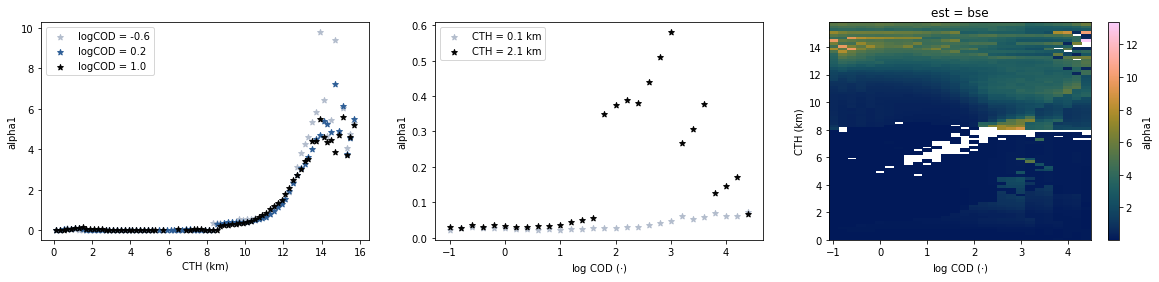

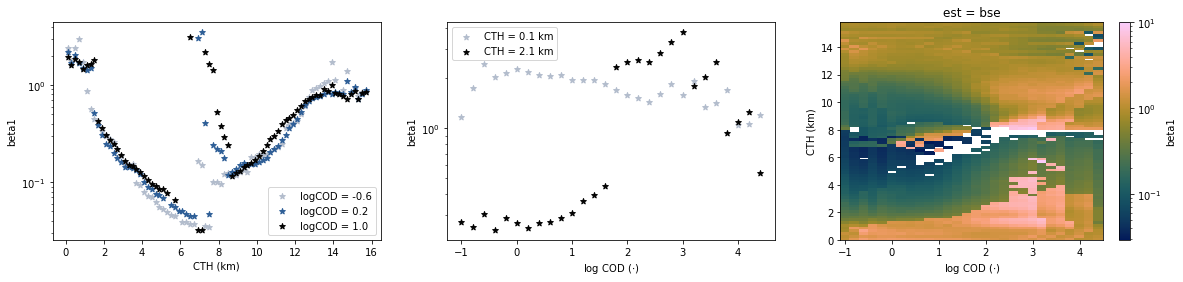

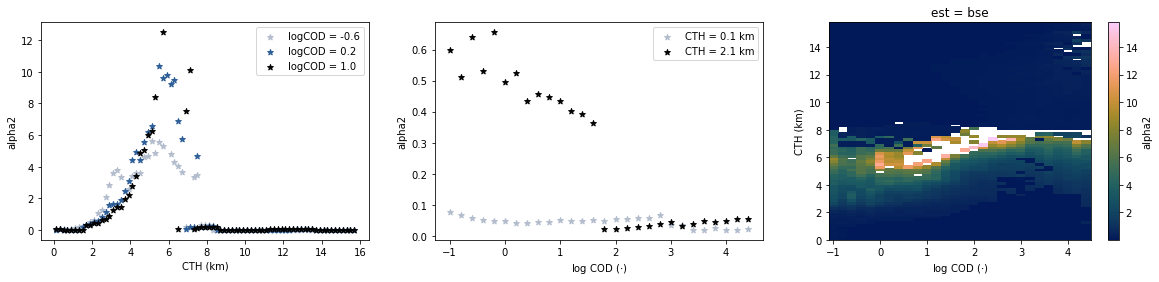

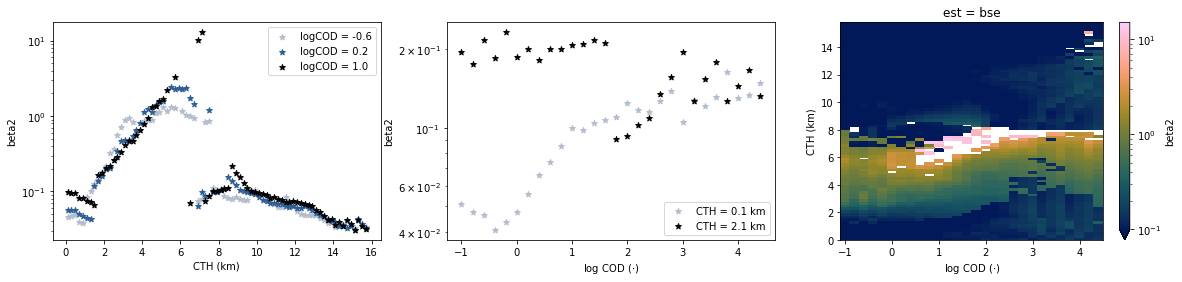

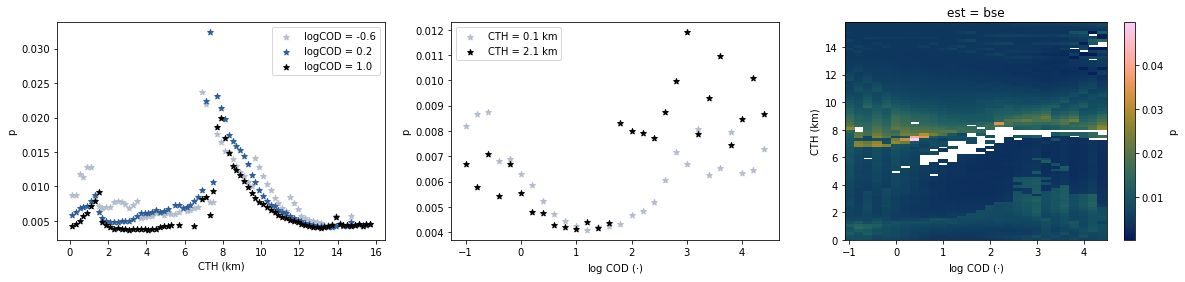

In [113]:
fig, ax = mp.plotLocalParam(ds_local.alpha1.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(ds_local.beta1.loc[:,:, 'bse'], logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(ds_local.alpha2.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(ds_local.beta2.loc[:,:, 'bse'], logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_p.png')


### Test Statistics



In [23]:
ds_local

<xarray.Dataset>
Dimensions:  (est: 2, method: 2, mu_d: 28, mu_h: 79)
Coordinates:
  * mu_h     (mu_h) float64 100.0 300.0 500.0 ... 1.53e+04 1.55e+04 1.57e+04
  * mu_d     (mu_d) float64 -1.0 -0.8 -0.6 -0.4 -0.2 ... 3.6 3.8 4.0 4.2 4.4
  * method   (method) object 'ML' 'MoM'
  * est      (est) object 'coef' 'bse'
Data variables: (12/26)
    p_cs     (mu_h, mu_d) float64 0.2162 0.236 0.2407 ... 0.002149 0.001235
    n_c      (mu_h, mu_d) float64 1.758e+04 1.102e+04 ... 7.446e+03 7.286e+03
    dH       (mu_h, mu_d) float64 900.0 600.0 400.0 ... 2.025e+03 2.025e+03
    dD       (mu_h, mu_d) float64 0.9 0.6 0.4 0.4 ... 2.025 2.025 2.025 2.025
    mu       (mu_h, mu_d) float64 0.1284 0.04318 0.02573 ... 4.239 4.302 4.347
    sigma    (mu_h, mu_d) float64 0.6472 0.6334 0.6048 ... 0.9475 0.8635 0.7991
    ...       ...
    AIC_b    (mu_h, mu_d, method) float64 -1.656e+04 nan ... -2.147e+04 nan
    BIC_b    (mu_h, mu_d, method) float64 -1.654e+04 nan ... -2.145e+04 nan
    KS_b     (mu_h, mu_d, method) float64 0.1673 0.2086 0.1765 ... 0.1689 0.165
    CM_b     (mu_h, mu_d, method) float64 107.4 132.7 69.26 ... 94.09 81.46
    AD_b     (mu_h, mu_d, method) float64 541.1 800.0 350.4 ... 509.6 439.3
    conv_b   (mu_h, mu_d, method) float64 1.0 nan 1.0 nan ... 1.0 nan 1.0 nan
Attributes:
    dh:       200
    dd:       0.2
    p_cscs:   0.7308294268298162

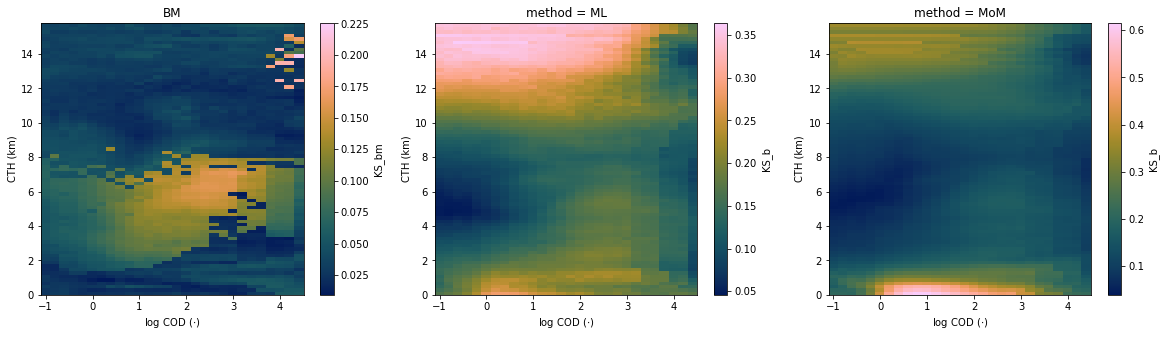

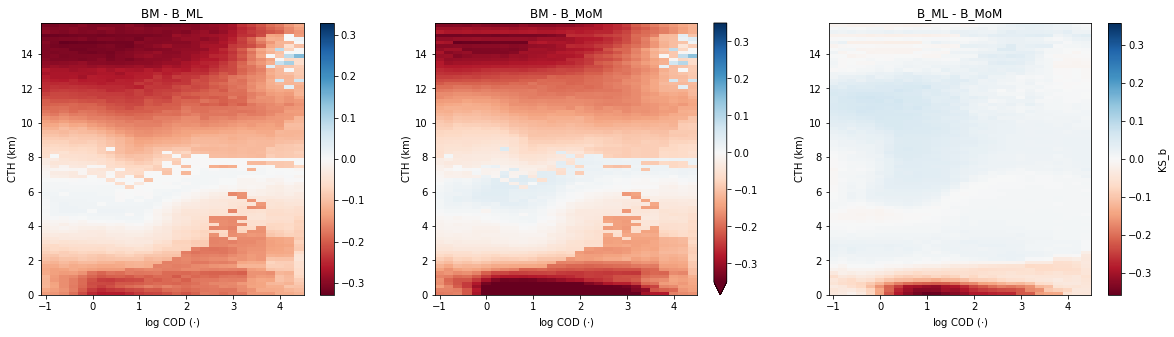

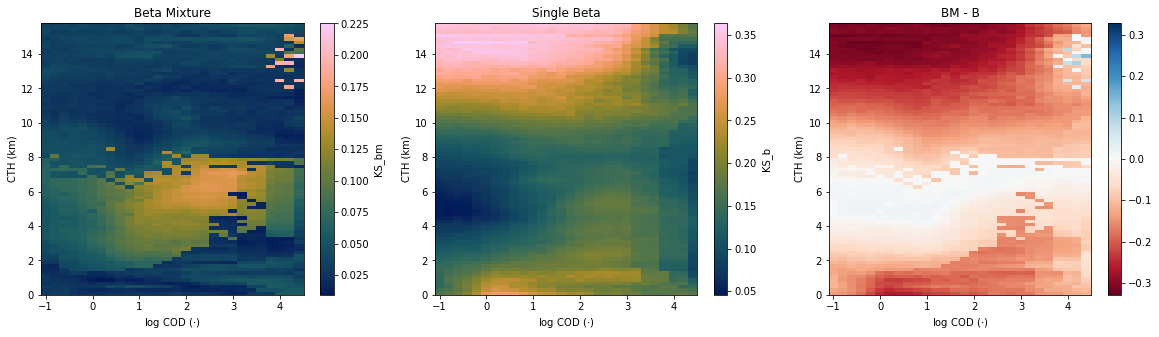

In [112]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.KS_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.KS_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.KS_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.KS_bm - ds_local.KS_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.KS_bm - ds_local.KS_b.loc[:,:, 'MoM'], cmap = cm.RdBu, vmin = -.35)
mp.plotLocalParam2d(ax[2], ds_local.KS_b.loc[:,:, 'ML'] - ds_local.KS_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.KS_bm)
ax[0].set_title('Beta Mixture')
mp.plotLocalParam2d(ax[1], ds_local.KS_b.loc[:,:, 'ML'])
ax[1].set_title('Single Beta')
mp.plotLocalParam2d(ax[2], ds_local.KS_bm - ds_local.KS_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[2].set_title('BM - B')
fig.savefig(loc_fig + 'goodness_of_fit.png')


plt.show()

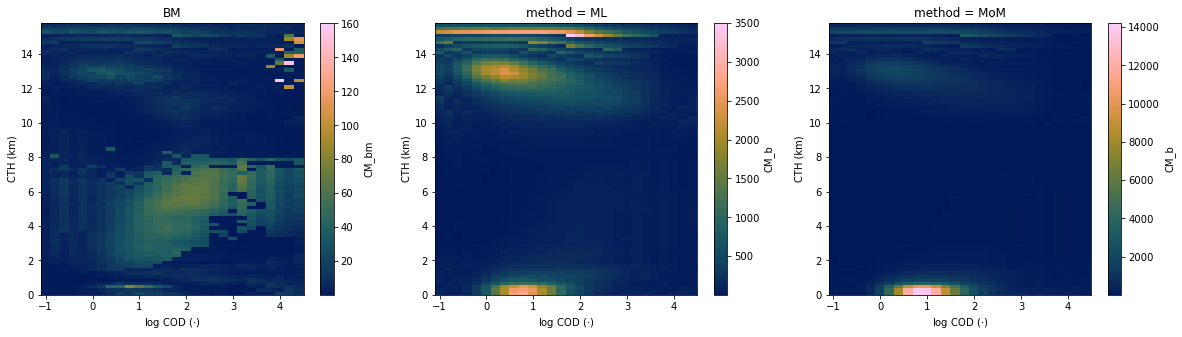

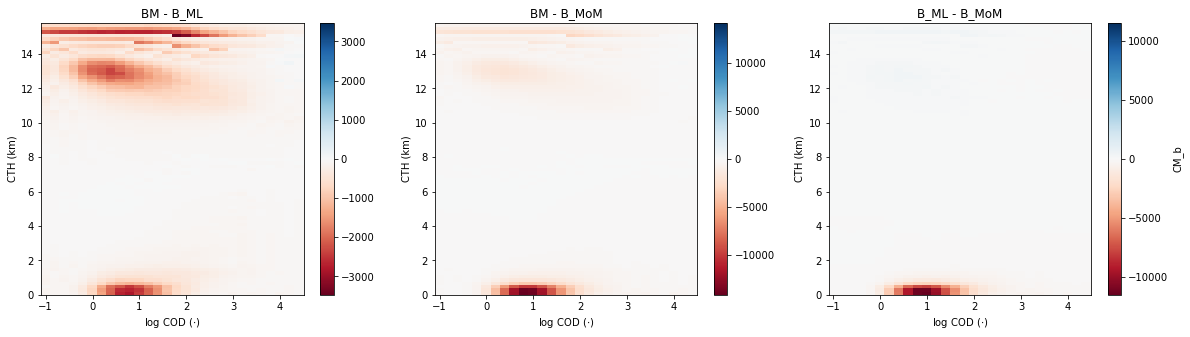

In [31]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.CM_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.CM_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.CM_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.CM_bm - ds_local.CM_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.CM_bm - ds_local.CM_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.CM_b.loc[:,:, 'ML'] - ds_local.CM_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

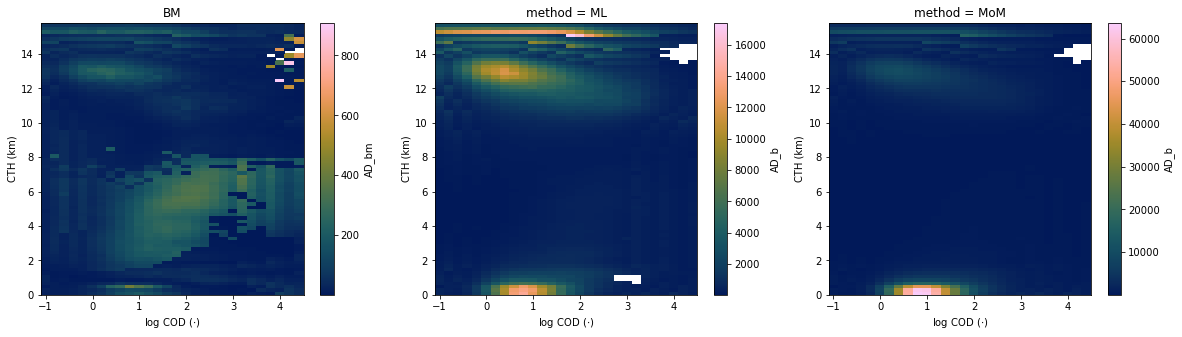

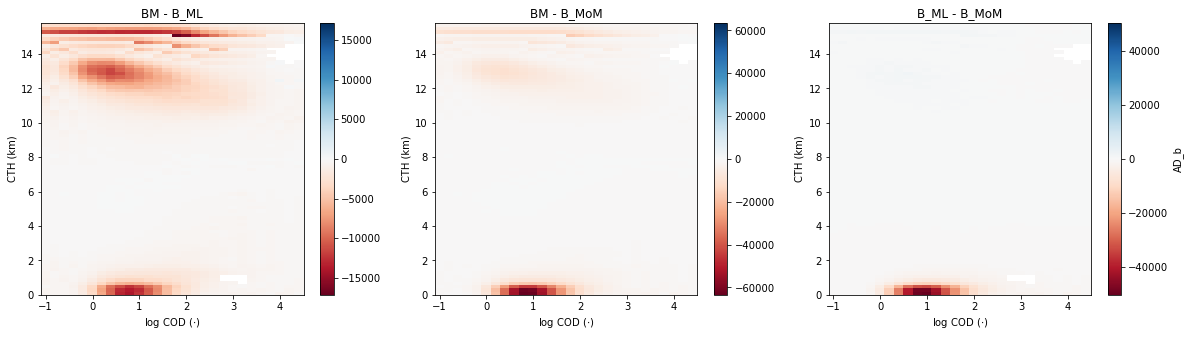

In [32]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.AD_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.AD_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.AD_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.AD_bm - ds_local.AD_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.AD_bm - ds_local.AD_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.AD_b.loc[:,:, 'ML'] - ds_local.AD_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

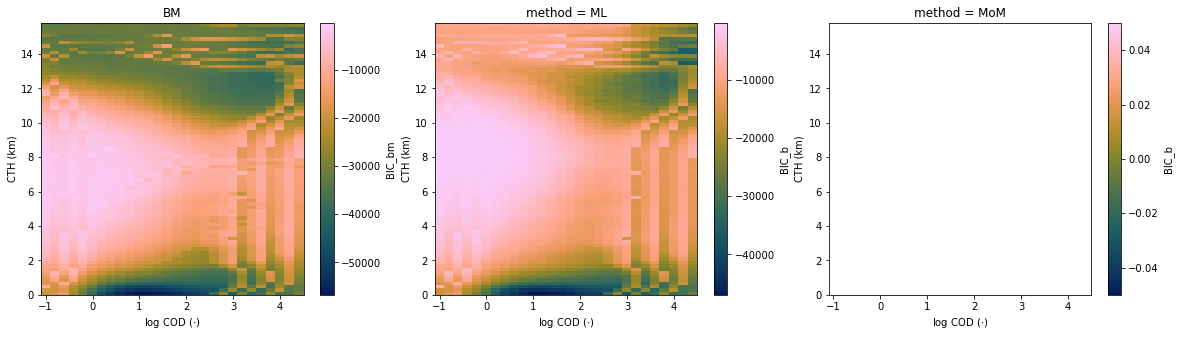

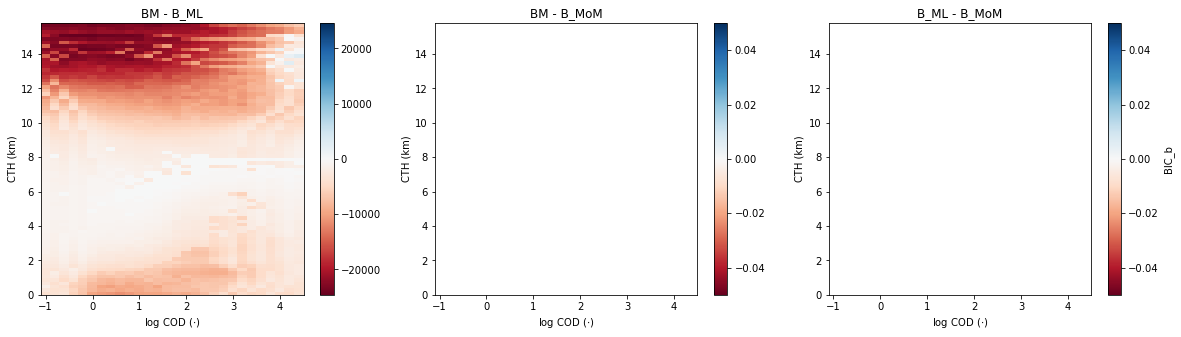

In [37]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.BIC_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.BIC_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.BIC_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.BIC_bm - ds_local.BIC_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.BIC_bm - ds_local.BIC_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.BIC_b.loc[:,:, 'ML'] - ds_local.BIC_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

## clear sky to cloud

## cloud to clear sky